In [11]:
import numpy as np
import pandas as pd

# import the training set and the test set
train_df = pd.read_csv("MSD_train.csv")
test_df = pd.read_csv("MSD_test.csv")

train_df.head()
#print(train_df.dtypes)

,track,artist,year,songHotness,artistFamiliarity,artistHotness,tempo,loudness,timeSignature,timeSignatureConfidence,...,meanSegmentTimbre_4,meanSegmentTimbre_5,meanSegmentTimbre_6,meanSegmentTimbre_7,meanSegmentTimbre_8,meanSegmentTimbre_9,meanSegmentTimbre_10,meanSegmentTimbre_11,meanSegmentTimbre_12,mood
0,WKYA (drop),Redman,2001,0.570106,0.743130,0.493567,85.008,-10.296,5,1.000,...,-2.237608,12.064915,8.435240,-12.736663,3.541857,11.157690,14.497049,-5.521335,3.968120,excited
1,Fat Tuesday,Chris Standring,2003,0.642091,0.564710,0.415938,111.039,-9.339,4,0.630,...,14.773515,5.724202,-3.561888,-1.947826,-2.080575,-14.514505,-8.273132,4.209038,-9.320261,happy
2,Touch My Body,Mariah Carey,2008,NaN,0.934935,0.787005,129.991,-5.558,4,0.306,...,18.134168,27.488662,1.695400,20.238338,-22.931903,-6.477831,-5.343169,-2.113650,-7.724559,calm
3,Hunter,30 Seconds To Mars,2005,0.792043,0.909325,0.677088,106.525,-10.807,3,1.000,...,-8.747707,-9.053734,-34.521766,8.631680,1.938273,8.422473,5.320331,4.975976,-4.049804,excited
4,Guajira Y Ven,Willie Colon,2001,NaN,0.621629,0.519120,128.444,-7.818,1,0.000,...,16.681111,-17.706970,17.143723,-2.253937,-4.069589,10.612725,6.683506,-3.913098,-1.582685,excited


In [12]:
# select indices of the features to be extracted
feature_indices = np.append(np.array([2,6,7,8,10,12]), np.arange(14,26))

# extract the relevant features values from the datasets
X_train = train_df.iloc[:,feature_indices]
X_test = test_df.iloc[:,feature_indices]

# extract the mood labels
y_train = train_df['mood']
y_test = test_df['mood']

In [13]:
#X_train.head()
print(X_train.shape)
print(X_train.dtypes)
print(y_train.shape)
print(y_train.dtypes)
feature_names = list(X_train)


(275, 18)
year                      int64
tempo                   float64
loudness                float64
timeSignature             int64
key                       int64
mode                      int64
meanSegmentTimbre_1     float64
meanSegmentTimbre_2     float64
meanSegmentTimbre_3     float64
meanSegmentTimbre_4     float64
meanSegmentTimbre_5     float64
meanSegmentTimbre_6     float64
meanSegmentTimbre_7     float64
meanSegmentTimbre_8     float64
meanSegmentTimbre_9     float64
meanSegmentTimbre_10    float64
meanSegmentTimbre_11    float64
meanSegmentTimbre_12    float64
dtype: object
(275,)
object


In [14]:
# import required modules from scikit-learn
from sklearn import svm
from sklearn.compose import make_column_transformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

In [15]:
# define a column transformer for one-hot encoding of the "key" feature
column_trans = make_column_transformer((preprocessing.OneHotEncoder(), ['key']),
                                      remainder = 'passthrough')

In [16]:
# define a grid of parameters to be explored by "GridSearchCV"
# just using the default values for C and gamma here
tuned_parameters = [
    {'svc__C': [1],#, 10, 100], 
     'svc__gamma': ['scale'],#, 0.1, 0.01, 0.001], 
     'svc__kernel': ['rbf']},
 ]
#  {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear']},
#  {'svc__C': [1, 10, 100, 1000], 'svc__gamma': ['scale', 'auto', 0.1, 0.01], 'svc__kernel': ['rbf']},
#  {'svc__C': [1, 10, 100], 'svc__degree': [2, 3, 4], 'svc__gamma': ['scale', 0.1, 0.01], 'svc__kernel': ['poly']},

# what kind of scoring is to be used by GridSearchCV for evaluation
scores = ['balanced_accuracy', 'f1_weighted']#, 'neg_log_loss']

# create a pipeline for the learning - column transformer is commented out
# the data is centered at zero and scaled for a variance of 1 before running SVC
mypipeline = make_pipeline(#column_trans,
                           preprocessing.StandardScaler(),
                           svm.SVC(cache_size=1000,class_weight='balanced',
                                   break_ties=False,probability=True)
                          )

# loop over the different scoring methods
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    # define the grid search object
    clf = GridSearchCV(mypipeline,
                       tuned_parameters, scoring=score, cv=5, n_jobs=-1
                      )
    # run the grid search on the training set
    clf.fit(X_train, y_train)

    # Print out the best set of parameters and the scoring for all attempted sets
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()


# Tuning hyper-parameters for balanced_accuracy

Best parameters set found on development set:

{'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Grid scores on development set:

0.471 (+/-0.095) for {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

# Tuning hyper-parameters for f1_weighted

Best parameters set found on development set:

{'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Grid scores on development set:

0.476 (+/-0.102) for {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}



In [17]:
# define a new pipeline with the best parameters and fit it to the full training set
best = mypipeline.set_params(**clf.best_params_)
best.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=1000,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

              precision    recall  f1-score   support

       angry       0.50      0.50      0.50         8
        calm       0.58      0.52      0.55        21
     excited       0.69      0.50      0.58        18
       happy       0.35      0.54      0.42        13
         sad       0.50      0.50      0.50        10

    accuracy                           0.51        70
   macro avg       0.52      0.51      0.51        70
weighted avg       0.55      0.51      0.52        70



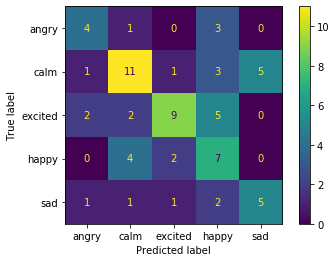

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# predict the test set labels using the learned model
# and get evaluation metrics and plot the confusion matrix
disp = plot_confusion_matrix(best, X_test, y_test, display_labels=None)
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))